### GCP bigquery example


In [1]:
# imports
import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

# tools for getting data
from google.cloud import bigquery

from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import wordcloud
import matplotlib.pyplot as plt


In [2]:
# do some setup to make sure visualization controls work
# from cli: jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [3]:
# get hackernews data using bigquery
# https://www.kaggle.com/sohier/beyond-queries-exploring-the-bigquery-api
# if you need to setup google api credentials, see this ref: https://cloud.google.com/docs/authentication/getting-started
# you may also need to use google cloud console to enable 'bigquery' for your query user/api key
# https://cloud.google.com/bigquery/docs/access-control
# hackernews feed updated daily:  https://medium.com/@hoffa/hacker-news-on-bigquery-now-with-daily-updates-so-what-are-the-top-domains-963d3c68b2e2
client = bigquery.Client()
hn_dataset_ref = client.dataset('hacker_news', project='bigquery-public-data')


In [4]:
# check that connection works
type(hn_dataset_ref)

google.cloud.bigquery.dataset.DatasetReference

In [5]:
hn_dset = client.get_dataset(hn_dataset_ref)
[x.table_id for x in client.list_tables(hn_dset)]

['comments', 'full', 'full_201510', 'stories']

In [8]:
hn_full = client.get_table(hn_dset.table('full'))
type(hn_full)

google.cloud.bigquery.table.Table

In [9]:
[command for command in dir(hn_full) if not command.startswith('_')]

['clustering_fields',
 'created',
 'dataset_id',
 'description',
 'encryption_configuration',
 'etag',
 'expires',
 'external_data_configuration',
 'friendly_name',
 'from_api_repr',
 'from_string',
 'full_table_id',
 'labels',
 'location',
 'modified',
 'num_bytes',
 'num_rows',
 'partition_expiration',
 'partitioning_type',
 'path',
 'project',
 'reference',
 'schema',
 'self_link',
 'streaming_buffer',
 'table_id',
 'table_type',
 'time_partitioning',
 'to_api_repr',
 'to_bqstorage',
 'view_query',
 'view_use_legacy_sql']

In [10]:
hn_full.schema

[SchemaField('by', 'STRING', 'NULLABLE', "The username of the item's author.", ()),
 SchemaField('score', 'INTEGER', 'NULLABLE', 'Story score', ()),
 SchemaField('time', 'INTEGER', 'NULLABLE', 'Unix time', ()),
 SchemaField('timestamp', 'TIMESTAMP', 'NULLABLE', 'Timestamp for the unix time', ()),
 SchemaField('title', 'STRING', 'NULLABLE', 'Story title', ()),
 SchemaField('type', 'STRING', 'NULLABLE', 'Type of details (comment, comment_ranking, poll, story, job, pollopt)', ()),
 SchemaField('url', 'STRING', 'NULLABLE', 'Story url', ()),
 SchemaField('text', 'STRING', 'NULLABLE', 'Story or comment text', ()),
 SchemaField('parent', 'INTEGER', 'NULLABLE', 'Parent comment ID', ()),
 SchemaField('deleted', 'BOOLEAN', 'NULLABLE', 'Is deleted?', ()),
 SchemaField('dead', 'BOOLEAN', 'NULLABLE', 'Is dead?', ()),
 SchemaField('descendants', 'INTEGER', 'NULLABLE', 'Number of story or poll descendants', ()),
 SchemaField('id', 'INTEGER', 'NULLABLE', "The item's unique id.", ()),
 SchemaField('ran

In [11]:
BYTES_PER_GB = 2**30
hn_full.num_bytes / BYTES_PER_GB

7.0778540931642056

In [12]:
def estimate_gigabytes_scanned(query, bq_client):
    # see https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
    my_job_config = bigquery.job.QueryJobConfig()
    my_job_config.dry_run = True
    my_job = bq_client.query(query, job_config=my_job_config)
    BYTES_PER_GB = 2**30
    return my_job.total_bytes_processed / BYTES_PER_GB

In [52]:
# if we've already downloaded the info, load the previously saved csv
headlines = pd.read_csv("hackernews_ML_articles.csv")

In [53]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1855 entries, 0 to 1854
Data columns (total 8 columns):
Unnamed: 0      1855 non-null int64
Unnamed: 0.1    1855 non-null int64
id              1855 non-null int64
author          1855 non-null object
title           1855 non-null object
time_ts         1855 non-null object
score           1855 non-null int64
url             1731 non-null object
dtypes: int64(4), object(4)
memory usage: 116.0+ KB


In [54]:
headlines.to_csv("hackernews_ML_articles.csv" ,  sep=',', header=True)

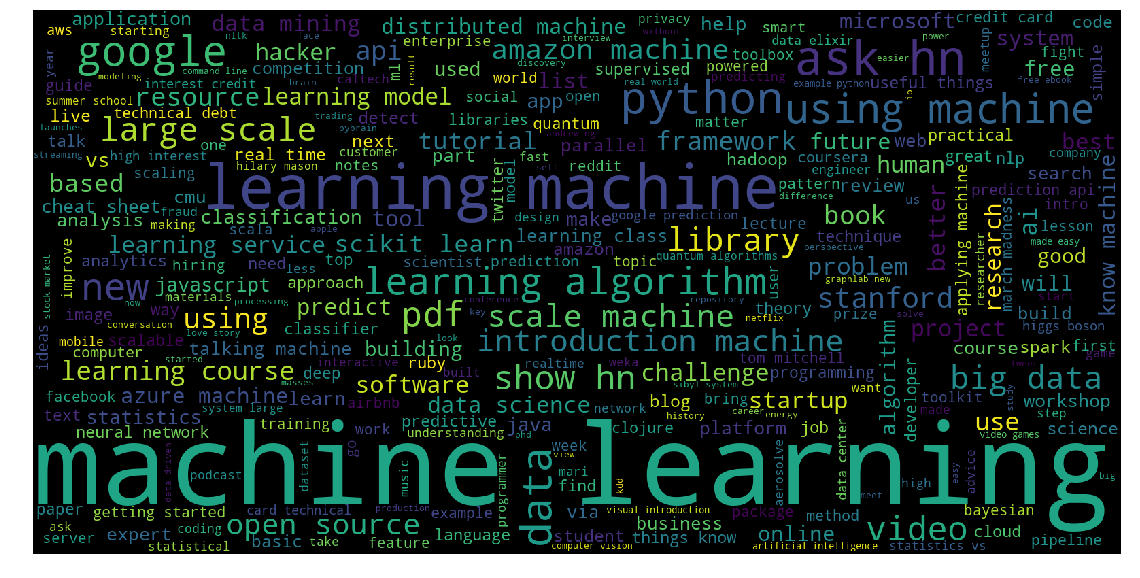

In [55]:
words = ' '.join(headlines.title).lower()
cloud = wordcloud.WordCloud(background_color='black',
                            max_font_size=200,
                            width=1600,
                            height=800,
                            max_words=300,
                            relative_scaling=.5).generate(words)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.savefig('kaggle-hackernews.png')
plt.imshow(cloud);

In [56]:
headlines.head(5)

,Unnamed: 0,Unnamed: 0.1,id,author,title,time_ts,score,url
0,0,0,9520,bootload,Delicious tags & machine learning,2007-04-06 03:58:32+00:00,1,http://www.smokingrobot.com/news/archives/perm...
1,1,1,46778,nickb,Machine Learning and The Privacy Problem,2007-08-26 18:34:47+00:00,2,http://hunch.net/?p=288
2,2,2,58532,aquarin,Map-Reduce for Machine Learning on Multicore (...,2007-09-23 13:08:53+00:00,10,http://www.cs.stanford.edu/people/ang//papers/...
3,3,3,58600,ivankirigin,Machine Learning Animations from CMU's Auton L...,2007-09-23 20:02:14+00:00,9,http://www.autonlab.org/autonweb/library/anima...
4,4,4,64637,tocomment,Machine Learning and Dragons - A Game,2007-10-08 05:18:34+00:00,22,http://www.blendedtechnologies.com/machine-lea...


In [57]:
# Generate a slider
@interact
def show_articles_more_than(column='score', x=int(headlines['score'].max()/3)):
    return headlines.loc[headlines[column] > x].sort_values(by="score", ascending=False)


interactive(children=(Text(value='score', description='column'), IntSlider(value=183, description='x', max=549…

In [58]:
import qgrid

In [59]:
# qgrid enables interactive filtering of the entire dataframe; more convenient than manual slicing
qgrid.show_grid(headlines)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [60]:
# breakout time data into useful columns
import datetime as dt

headlines['time_ts'] = pd.to_datetime(headlines['time_ts'])   # cast to datetime type

headlines['year'] = pd.DatetimeIndex(headlines['time_ts']).year
headlines['month'] = pd.DatetimeIndex(headlines['time_ts']).month
headlines['day'] = pd.DatetimeIndex(headlines['time_ts']).day
headlines['day_name'] = headlines[['time_ts']].apply(lambda x: dt.datetime.strftime(x['time_ts'], '%A'), axis=1)

In [61]:
headlines.head(5)

,Unnamed: 0,Unnamed: 0.1,id,author,title,time_ts,score,url,year,month,day,day_name
0,0,0,9520,bootload,Delicious tags & machine learning,2007-04-06 03:58:32+00:00,1,http://www.smokingrobot.com/news/archives/perm...,2007,4,6,Friday
1,1,1,46778,nickb,Machine Learning and The Privacy Problem,2007-08-26 18:34:47+00:00,2,http://hunch.net/?p=288,2007,8,26,Sunday
2,2,2,58532,aquarin,Map-Reduce for Machine Learning on Multicore (...,2007-09-23 13:08:53+00:00,10,http://www.cs.stanford.edu/people/ang//papers/...,2007,9,23,Sunday
3,3,3,58600,ivankirigin,Machine Learning Animations from CMU's Auton L...,2007-09-23 20:02:14+00:00,9,http://www.autonlab.org/autonweb/library/anima...,2007,9,23,Sunday
4,4,4,64637,tocomment,Machine Learning and Dragons - A Game,2007-10-08 05:18:34+00:00,22,http://www.blendedtechnologies.com/machine-lea...,2007,10,8,Monday
